# Velocity distribution

In this notebook we explore how the velocity distribution of Argon particles develop in time starting from a an unphysical uniform distribution. According to the central limit theorem the velocity distrbituion should go to a Maxwell-Boltzmann distribution.

In [1]:
import sys

sys.path.append("..")

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from read_lammps_dump import read_dump

sns.set(color_codes=True)

We start by reading in the simulation dump from lammps.

In [3]:
df, num_atoms, bounds = read_dump("dump.lammpstrj")

In [5]:
df.head()

,id,type,x,y,z,vx,vy,vz,timestep
0,1,1,0.00000,0.00000,0.00000,1.013020,0.194801,0.138771,0
1,2,1,3.68403,3.68403,0.00000,-1.673840,0.826244,-1.131720,0
2,3,1,3.68403,0.00000,3.68403,-0.633593,-2.411290,1.367270,0
3,4,1,0.00000,3.68403,3.68403,0.220096,1.331590,-1.096720,0
4,5,1,7.36806,0.00000,0.00000,-0.146018,1.056760,0.050760,0


In [6]:
df.tail()

,id,type,x,y,z,vx,vy,vz,timestep
16031995,31996,1,132.8560,37.22080,15.73670,1.852340,3.519550,-0.765361,5000
16031996,31997,1,120.1950,89.51820,50.15320,-1.052400,-0.689569,-2.870400,5000
16031997,31998,1,14.2062,9.04787,102.55200,-0.682927,-0.092327,-1.266210,5000
16031998,31999,1,40.3668,145.19500,4.75542,1.804220,-0.427913,0.007571,5000
16031999,32000,1,118.9060,146.56200,28.41280,-0.469721,-1.489710,1.732850,5000


The simulation we've run is run for $N$ particles, $n$ timesteps and a simulation box with sides $[0, L)$.

In [19]:
n = df.loc[len(df) - 1, "timestep"]
num_timesteps = n // 10
sigma = 3.405 # Ångström
L = bounds[0][1] * sigma

print(f"N = {num_atoms}")
print(f"n = {n}")
print(f"L = {L} Ångström")

N = 32000
n = 5000
L = 501.76509011482057 Ångström


## Adding velocity magnitude

From the simulation we have the velocity components $\mathbf{v}_i = (v_i^x, v_i^y, v_i^z)$ for every particle $i$. Initially they are in a uniform distribution with boundaries $v_i^j \in [-2.5, 2.5]$. The uniform distribution will be evident in the histogram plots for the velocity components. To better see the Maxwell-Boltzmann distribution we add the velocity magnitude of a particle by
\begin{align}
    v_i = |\mathbf{v}_i| = \sqrt{{v_i^x}^2 + {v_i^y}^2 + {v_i^z}^2},
\end{align}
as the cartesian components will look like Gaussians in a Maxwell-Boltzmann distribution.

In [12]:
df["v"] = np.sqrt(
    df["vx"] ** 2
    + df["vy"] ** 2
    + df["vz"] ** 2
)

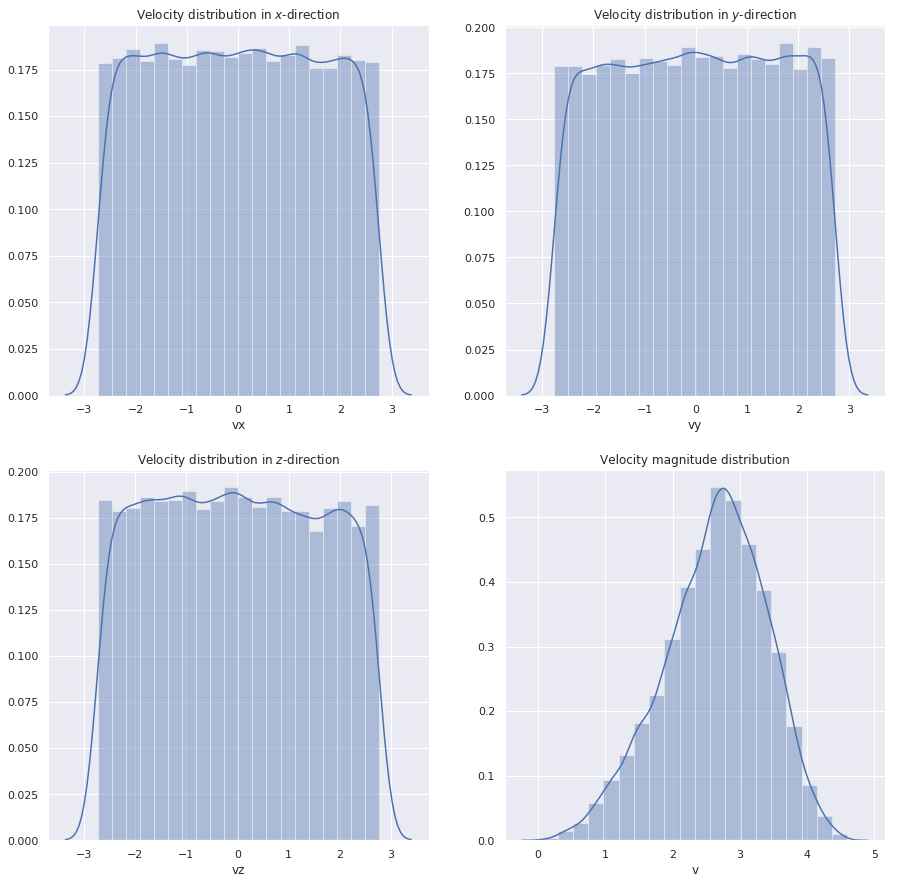

In [13]:
num_bins = 20

fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.distplot(df.iloc[:num_atoms].vx, bins=num_bins)
plt.title(r"Velocity distribution in $x$-direction")

plt.subplot(2, 2, 2)
sns.distplot(df.iloc[:num_atoms].vy, bins=num_bins)
plt.title(r"Velocity distribution in $y$-direction")

plt.subplot(2, 2, 3)
sns.distplot(df.iloc[:num_atoms].vz, bins=num_bins)
plt.title(r"Velocity distribution in $z$-direction")

plt.subplot(2, 2, 4)
sns.distplot(df.iloc[:num_atoms].v, bins=num_bins)
plt.title(r"Velocity magnitude distribution")

plt.show()

Here we can see the initial velocity distribution for each component and the velocity magnitude. The cartesian components clearly show the shape of a uniform distribution in the interval $[-2.5, 2.5]$.

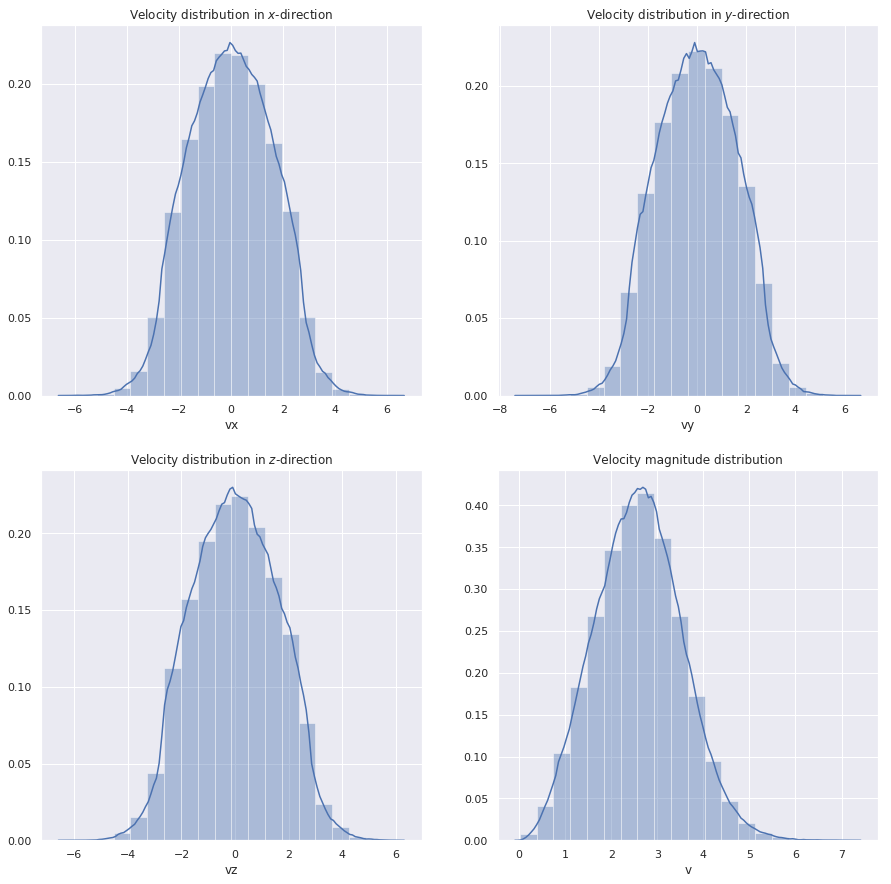

In [14]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.distplot(df.iloc[num_atoms:].vx, bins=num_bins)
plt.title(r"Velocity distribution in $x$-direction")

plt.subplot(2, 2, 2)
sns.distplot(df.iloc[num_atoms:].vy, bins=num_bins)
plt.title(r"Velocity distribution in $y$-direction")

plt.subplot(2, 2, 3)
sns.distplot(df.iloc[num_atoms:].vz, bins=num_bins)
plt.title(r"Velocity distribution in $z$-direction")

plt.subplot(2, 2, 4)
sns.distplot(df.iloc[num_atoms:].v, bins=num_bins)
plt.title(r"Velocity magnitude distribution")

plt.show()

In these plots we see the expected normal distribution for the cartesian components, whereas the velocity magnitude shows the behaviour of a radial Maxwell-Boltzmann distribution.

## Quantizing the time it takes to reach the Maxwell-Boltzmann distribution

In order to determine how long time (or how many timesteps) it takes for the system to reach a Maxwell-Boltzmann distribution, we compute the normalized overlap between the histograms at every timestep with the final histogram. That is, the overlap $o_i$ is given by
\begin{align}
        o_i = \frac{\langle h_i, h_{n} \rangle}{\sqrt{\langle h_i, h_i \rangle \langle h_n, h_n \rangle}},
\end{align}

where we've normalized the overlap.

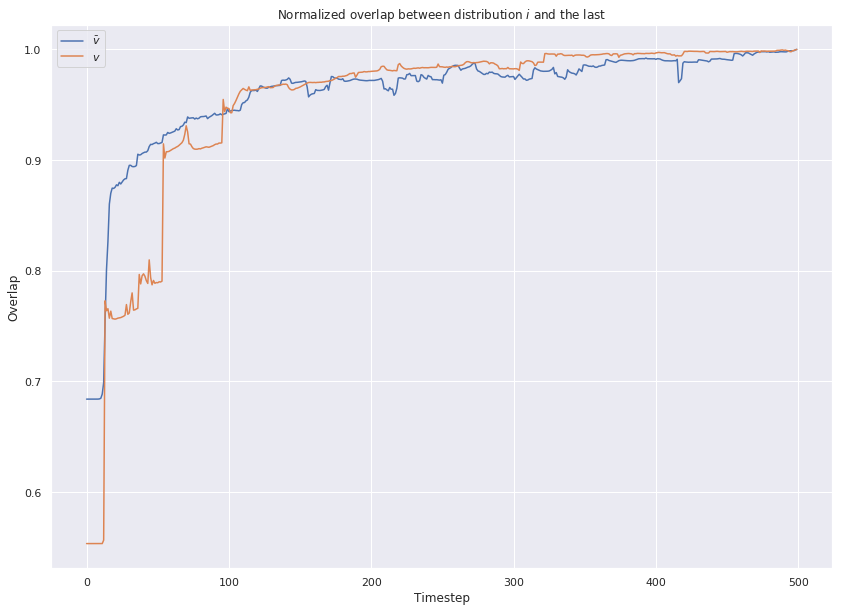

In [26]:
fig = plt.figure(figsize=(14, 10))
timesteps = np.arange(num_timesteps)
last_slice = slice((num_timesteps - 1) * num_atoms, num_timesteps * num_atoms)
overlap = np.zeros((4, num_timesteps))
num_bins = 100

for o_i, v in enumerate(["vx", "vy", "vz", "v"]):
    last_hist, bins = np.histogram(df.loc[last_slice, v], bins=num_bins)
    norm = np.sqrt(np.dot(last_hist, last_hist))

    for i in range(num_timesteps):
        t_i = slice(i * num_atoms, (i + 1) * num_atoms)
        hist, bins = np.histogram(df.loc[t_i, v], bins=num_bins)
        norm_i = np.sqrt(np.dot(hist, hist))
        overlap[o_i, i] = np.dot(hist, last_hist) / (norm * norm_i)

    #plt.plot(timesteps, overlap[o_i], label=fr"${v}$")

plt.plot(timesteps, np.mean(overlap[:3], axis=0), label=r"$\bar{v}$")
plt.plot(timesteps, overlap[-1], label=r"$v$")
plt.legend(loc="best")
plt.xlabel(r"Timestep")
plt.ylabel(r"Overlap")
plt.title(r"Normalized overlap between distribution $i$ and the last")
plt.show()

In this figure we can see how both the mean velocity, i.e., the mean of the three cartesian components, and the velocity magnitude moves toward the final distribution which resembles the Maxwell-Boltzmann distribution.